In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.python.data import Dataset
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
import math

In [19]:
california_data=pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")
california_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [20]:
#Shuffling
california_data = california_data.reindex(np.random.permutation(california_data.index))

In [21]:
def preprocess_features(california_data):
    selected_features = california_data[['longitude','latitude','housing_median_age',
                          'total_rooms','total_bedrooms','population','households','median_income']]
    processed_features = selected_features.copy()
    processed_features['rooms_per_person'] = (selected_features['total_rooms']/selected_features['population'])
    return processed_features
def preprocess_targets(california_data):
    output_targets = pd.DataFrame()
    output_targets['median_house_value'] = (california_data['median_house_value']/1000)
    return output_targets


In [9]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val)/2
    return series.apply(lambda x: ((x - min_val)/scale)-1)

    

In [ ]:
def normalize_inputs(california_data):
    processed_data = pd.DataFrame()
    processed_data['latitude'] = linear_scale(california_data['latitude'])
    processed_data['longitude'] = linear_scale(california_data['longitude'])
    processed_data['housing_median_age'] = linear_scale(california_data['housing_median_age'])
    processed_data['total_rooms'] = linear_scale(california_data['total_rooms'])
    processed_data['population'] = linear_scale(california_data['population'])
    processed_data['households'] = linear_scale(california_data['households'])
    processed_data['median_income'] = linear_scale(california_data['median_income'])
    processed_data['rooms_per_person'] = linear_scale(california_data['rooms_per_person'])
    return processed_data

In [28]:
#Trying log normalization
def log_normalize(series):
    return series.apply(lambda x: math.log(abs(x)+1.0))

In [29]:
def normalize_inputs(california_data):
    processed_data = pd.DataFrame()
    processed_data['latitude'] = log_normalize(california_data['latitude'])
    processed_data['longitude'] = log_normalize(california_data['longitude'])
    processed_data['housing_median_age'] = log_normalize(california_data['housing_median_age'])
    processed_data['total_rooms'] = log_normalize(california_data['total_rooms'])
    processed_data['population'] = log_normalize(california_data['population'])
    processed_data['households'] = log_normalize(california_data['households'])
    processed_data['median_income'] = log_normalize(california_data['median_income'])
    processed_data['rooms_per_person'] = log_normalize(california_data['rooms_per_person'])
    return processed_data

In [30]:
#Split training and validation data 
training_examples = normalize_inputs(preprocess_features(california_data.head(12000)))
training_targets = preprocess_targets(california_data.head(12000))

validation_examples = normalize_inputs(preprocess_features(california_data.tail(5000)))
validation_targets = preprocess_targets(california_data.tail(5000))

#Make sure both represents same descriptive stats
print(training_examples.describe())
print(validation_examples.describe())


       latitude  longitude  housing_median_age  total_rooms  population  \
count   12000.0    12000.0             12000.0      12000.0     12000.0   
mean        3.6        4.8                 3.3          7.6         7.0   
std         0.1        0.0                 0.5          0.7         0.7   
min         3.5        4.7                 0.7          2.5         1.4   
25%         3.6        4.8                 2.9          7.3         6.7   
50%         3.6        4.8                 3.4          7.7         7.1   
75%         3.7        4.8                 3.6          8.1         7.5   
max         3.8        4.8                 4.0         10.4        10.3   

       households  median_income  rooms_per_person  
count     12000.0        12000.0           12000.0  
mean          6.0            1.5               1.1  
std           0.7            0.4               0.2  
min           1.1            0.4               0.1  
25%           5.6            1.3               0.9  
50%   

In [31]:
def construct_feature_columns(training_examples):
    return set([tf.feature_column.numeric_column(feature) for feature in training_examples])

def my_input_fn(features, targets, batch_size=1,  num_epochs = None, shuffle = True):
    #convert pandas features into dict of numpy arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features, targets = ds.make_one_shot_iterator().get_next()
    return features,targets
    

In [32]:
def my_train(training_examples, training_targets, validation_examples, validation_targets, 
             learning_rate, steps, batch_size, hidden_units):
    #define input functions for training, prediction and validation
    training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'])
    training_predict_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], batch_size=batch_size, num_epochs=1, shuffle=False)
    validation_predict_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], batch_size = batch_size, num_epochs = 1, shuffle = False)
    
    #configure NNregressor
    my_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(feature_columns=construct_feature_columns(training_examples),
                                             optimizer = my_optimizer, hidden_units = hidden_units)
    
    periods = 10
    steps_per_period = steps/periods
    training_RMSE = []
    validation_RMSE = []
    #train in a loop, pause for every 10 steps and show loss
    for period in range(1,periods):
        dnn_regressor.train(input_fn = training_input_fn, steps = steps_per_period)
        
        training_predictions = dnn_regressor.predict(input_fn = training_predict_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = dnn_regressor.predict(input_fn = validation_predict_fn)
        validation_predictions = np.array([item['predictions'][0]  for item in validation_predictions])
        
        training_rmse = math.sqrt(metrics.mean_squared_error(training_targets, training_predictions))
        validation_rmse = math.sqrt(metrics.mean_squared_error(validation_targets, validation_predictions))
        print("period: ", period)
        print("training_rmse: ",training_rmse)
        print("validation_rmse: ",validation_rmse)
        training_RMSE.append(training_rmse)
        validation_RMSE.append(validation_rmse)
    print("Model training finished..")
    print("Final training rmse: ", training_RMSE)
    print("Final validation rmse: ", validation_RMSE)
    return dnn_regressor
                                                       

In [33]:
DNN_regressor = my_train(training_examples, training_targets, validation_examples, validation_targets,
                        learning_rate = 0.005, steps = 10000,
                        batch_size = 50,hidden_units = [10,20,30,40])

period:  1
training_rmse:  111.4213102681692
validation_rmse:  115.11110955151136
period:  2
training_rmse:  114.76457523127374
validation_rmse:  118.91340584186385
period:  3
training_rmse:  89.08146090961942
validation_rmse:  92.2012006842284
period:  4
training_rmse:  85.93687490994061
validation_rmse:  86.1171499040107
period:  5
training_rmse:  102.98212296651447
validation_rmse:  101.72363159797573
period:  6
training_rmse:  89.99049971223626
validation_rmse:  93.29087082340534
period:  7
training_rmse:  83.0201325941633
validation_rmse:  86.3124929995756
period:  8
training_rmse:  84.05716098360865
validation_rmse:  86.83248495215034
period:  9
training_rmse:  78.81401333971534
validation_rmse:  81.86681491771105
Model training finished..
Final training rmse:  [111.4213102681692, 114.76457523127374, 89.08146090961942, 85.93687490994061, 102.98212296651447, 89.99049971223626, 83.0201325941633, 84.05716098360865, 78.81401333971534]
Final validation rmse:  [115.11110955151136, 118.

In [34]:
#Model is ready with RMSE of 71. Test the model on test data
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")
california_housing_test_data = california_housing_test_data.reindex(np.random.permutation(california_housing_test_data.index))
california_housing_test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,-119.6,35.6,28.8,2599.6,530.0,1402.8,489.9,3.8,205846.3
std,2.0,2.1,12.6,2155.6,415.7,1030.5,365.4,1.9,113119.7
min,-124.2,32.6,1.0,6.0,2.0,5.0,2.0,0.5,22500.0
25%,-121.8,33.9,18.0,1401.0,291.0,780.0,273.0,2.5,121200.0
50%,-118.5,34.3,29.0,2106.0,437.0,1155.0,409.5,3.5,177650.0
75%,-118.0,37.7,37.0,3129.0,636.0,1742.8,597.2,4.7,263975.0
max,-114.5,41.9,52.0,30450.0,5419.0,11935.0,4930.0,15.0,500001.0


In [35]:
test_examples = normalize_inputs(preprocess_features(california_housing_test_data))
test_targets = preprocess_targets(california_housing_test_data)
test_examples.head()
test_targets.head()

,median_house_value
798,204.5
708,167.6
1597,191.1
1248,388.5
953,161.1


In [36]:
test_predict_fn = lambda: my_input_fn(test_examples, test_targets['median_house_value'],batch_size=1, shuffle=False, num_epochs=1)
test_predictions = DNN_regressor.predict(input_fn=test_predict_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_rmse = math.sqrt(metrics.mean_squared_error(test_targets,test_predictions))
print("test rmse: ", test_rmse)

test rmse:  80.59778684071138


In [37]:
calibrated_data = pd.DataFrame()
calibrated_data['targets'] = test_targets['median_house_value']
calibrated_data['predictions'] = test_predictions
calibrated_data.head()

,targets,predictions
798,204.5,223.3
708,167.6,180.3
1597,191.1,157.9
1248,388.5,343.8
953,161.1,114.0


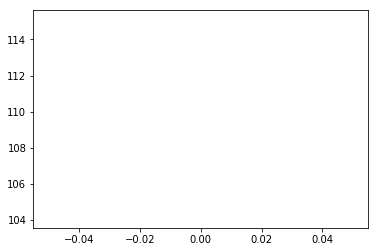

NameError: name 'training_predictions' is not defined